# Labeling and MetaLabeling

## Overview

In this chapter of the book AFML, De Prado introduces several novel techniques for labeling returns for the purposes of supervised machine learning.

First he identifies the typical issues of fixed-time horizon labeling methods - primarily that it is easy to mislabel a return due to dynamic nature of volatility throughout a trading period.

More importantly he addresses a major overlooked aspect of the financial literature. He emphasizes that every investment strategy makes use of stop-loss limits of some kind, whether those are enforced by a margin call, risk department or self-imposed. He highlights how unrealistic it is to test/implement/propagate a strategy that profits from positions that would have been stopped out.

> That virtually no publication accounts for that when labeling observations tells you something about the current state of financial literature.
> -De Prado, "Advances in Financial Machine Learning", pg.44

He also introduces a technique called metalabeling, which is used to augment a strategy by improving recall while also reducing the likelihood of overfitting.


In [1]:
%matplotlib widget
%reload_ext watermark
%watermark

%reload_ext autoreload
%autoreload 2

# import standard libs
from IPython.display import display
from IPython.core.debugger import set_trace as bp
from pathlib import PurePath, Path
import sys
import time
from collections import OrderedDict as od
import re
import os
import json

# import python scientific stack
import pandas as pd
import pandas_datareader.data as web
pd.set_option('display.max_rows', 100)
from dask import dataframe as dd
from dask.diagnostics import ProgressBar
from multiprocessing import cpu_count
pbar = ProgressBar()
pbar.register()
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from numba import jit
import math
import ffn

# import visual tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns

plt.style.use('seaborn-talk')
plt.style.use('bmh')
#plt.rcParams['font.family'] = 'DejaVu Sans Mono'
plt.rcParams['font.size'] = 9.5
plt.rcParams['font.weight'] = 'medium'
plt.rcParams['figure.figsize'] = 10,7
blue, green, red, purple, gold, teal = sns.color_palette('colorblind', 6)

# import util libs
from tqdm import tqdm, tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
import missingno as msno
from utils import get_relative_project_dir
import bars as brs
# import src.features.snippets as snp

RANDOM_STATE = 777

pdir = get_relative_project_dir('Advances-in-Financial-Machine-Learning', partial=False)
data_dir = pdir / 'data'

print()
%watermark -p pandas,pandas_datareader,dask,numpy,sklearn,statsmodels,scipy,ffn,matplotlib,seaborn

Last updated: 2024-03-14T23:34:11.563497+07:00

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 8.12.3

Compiler    : GCC 9.4.0
OS          : Linux
Release     : 5.15.0-56-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 12
Architecture: 64bit


pandas           : 2.0.3
pandas_datareader: 0.10.0
dask             : 2023.5.0
numpy            : 1.24.4
sklearn          : 0.0
statsmodels      : 0.14.1
scipy            : 1.10.1
ffn              : 1.0.1
matplotlib       : 3.7.5
seaborn          : 0.13.2



/tmp/ipykernel_1179185/424801526.py:42: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-talk')


## Code Snippets
### Symmetric CUSUM Filter [2.5.2.1]

In [2]:
def getTEvents(gRaw, h):
    tEvents, sPos, sNeg = [], 0, 0
    diff = np.log(gRaw).diff().dropna()
    for i in tqdm(diff.index[1:]):
        try:
            pos, neg = float(sPos+diff.loc[i]), float(sNeg+diff.loc[i])
        except Exception as e:
            print(e)
            print(sPos+diff.loc[i], type(sPos+diff.loc[i]))
            print(sNeg+diff.loc[i], type(sNeg+diff.loc[i]))
            break
        sPos, sNeg=max(0., pos), min(0., neg)
        if sNeg<-h:
            sNeg=0;tEvents.append(i)
        elif sPos>h:
            sPos=0;tEvents.append(i)
    return pd.DatetimeIndex(tEvents)


### Daily Volatility Estimator [3.1]

In [3]:
def getDailyVol(close,span0=100):
    # daily vol reindexed to close
    df0=close.index.searchsorted(close.index-pd.Timedelta(days=1))
    df0=df0[df0>0]   
    df0=(pd.Series(close.index[df0-1], 
                   index=close.index[close.shape[0]-df0.shape[0]:]))   
    try:
        df0=close.loc[df0.index]/close.loc[df0.values].values-1 # daily rets
    except Exception as e:
        print(f'error: {e}\nplease confirm no duplicate indices')
    df0=df0.ewm(span=span0).std().rename('dailyVol')
    return df0

### Triple-Barrier Labeling Method [3.2]

In [4]:
def applyPtSlOnT1(close,events,ptSl,molecule):
    # apply stop loss/profit taking, if it takes place before t1 (end of event)
    events_=events.loc[molecule]
    out=events_[['t1']].copy(deep=True)
    if ptSl[0]>0: pt=ptSl[0]*events_['trgt']
    else: pt=pd.Series(index=events.index) # NaNs
    if ptSl[1]>0: sl=-ptSl[1]*events_['trgt']
    else: sl=pd.Series(index=events.index) # NaNs
    for loc,t1 in events_['t1'].fillna(close.index[-1]).iteritems():
        df0=close[loc:t1] # path prices
        df0=(df0/close[loc]-1)*events_.at[loc,'side'] # path returns
        out.loc[loc,'sl']=df0[df0<sl[loc]].index.min() # earliest stop loss
        out.loc[loc,'pt']=df0[df0>pt[loc]].index.min() # earliest profit taking
    return out

### Gettting Time of First Touch (getEvents) [3.3], [3.6]

In [5]:
def getEvents(close, tEvents, ptSl, trgt, minRet, numThreads, t1=False, side=None):
    #1) get target
    trgt=trgt.loc[tEvents]
    trgt=trgt[trgt>minRet] # minRet
    #2) get t1 (max holding period)
    if t1 is False:t1=pd.Series(pd.NaT, index=tEvents)
    #3) form events object, apply stop loss on t1
    if side is None:side_,ptSl_=pd.Series(1.,index=trgt.index), [ptSl[0],ptSl[0]]
    else: side_,ptSl_=side.loc[trgt.index],ptSl[:2]
    events=(pd.concat({'t1':t1,'trgt':trgt,'side':side_}, axis=1)
            .dropna(subset=['trgt']))
    df0=mpPandasObj(func=applyPtSlOnT1,pdObj=('molecule',events.index),
                    numThreads=numThreads,close=close,events=events,
                    ptSl=ptSl_)
    events['t1']=df0.dropna(how='all').min(axis=1) # pd.min ignores nan
    if side is None:events=events.drop('side',axis=1)
    return events

### Adding Vertical Barrier [3.4]

In [6]:
def addVerticalBarrier(tEvents, close, numDays=1):
    t1=close.index.searchsorted(tEvents+pd.Timedelta(days=numDays))
    t1=t1[t1<close.shape[0]]
    t1=(pd.Series(close.index[t1],index=tEvents[:t1.shape[0]]))
    return t1

### Labeling for side and size [3.5]

In [7]:
def getBinsOld(events,close):
    #1) prices aligned with events
    events_=events.dropna(subset=['t1'])
    px=events_.index.union(events_['t1'].values).drop_duplicates()
    px=close.reindex(px,method='bfill')
    #2) create out object
    out=pd.DataFrame(index=events_.index)
    out['ret']=px.loc[events_['t1'].values].values/px.loc[events_.index]-1
    out['bin']=np.sign(out['ret'])
    # where out index and t1 (vertical barrier) intersect label 0
    try:
        locs = out.query('index in @t1').index
        out.loc[locs, 'bin'] = 0
    except:
        pass
    return out

### Expanding getBins to Incorporate Meta-Labeling [3.7]

In [8]:
def getBins(events, close):
    '''
    Compute event's outcome (including side information, if provided).
    events is a DataFrame where:
    -events.index is event's starttime
    -events['t1'] is event's endtime
    -events['trgt'] is event's target
    -events['side'] (optional) implies the algo's position side
    Case 1: ('side' not in events): bin in (-1,1) <-label by price action
    Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    '''
    #1) prices aligned with events
    events_=events.dropna(subset=['t1'])
    px=events_.index.union(events_['t1'].values).drop_duplicates()
    px=close.reindex(px,method='bfill')
    #2) create out object
    out=pd.DataFrame(index=events_.index)
    out['ret']=px.loc[events_['t1'].values].values/px.loc[events_.index]-1
    if 'side' in events_:out['ret']*=events_['side'] # meta-labeling
    out['bin']=np.sign(out['ret'])
    if 'side' in events_:out.loc[out['ret']<=0,'bin']=0 # meta-labeling
    return out

### Dropping Unnecessary Labels [3.8]

In [9]:
def dropLabels(events, minPct=.05):
    # apply weights, drop labels with insufficient examples
    while True:
        df0=events['bin'].value_counts(normalize=True)
        if df0.min()>minPct or df0.shape[0]<3:break
        print('dropped label: ', df0.argmin(),df0.min())
        events=events[events['bin']!=df0.argmin()]
    return events

### Linear Partitions [20.4.1]

In [10]:
def linParts(numAtoms,numThreads):
    # partition of atoms with a single loop
    parts=np.linspace(0,numAtoms,min(numThreads,numAtoms)+1)
    parts=np.ceil(parts).astype(int)
    return parts

In [11]:
def nestedParts(numAtoms,numThreads,upperTriang=False):
    # partition of atoms with an inner loop
    parts,numThreads_=[0],min(numThreads,numAtoms)
    for num in range(numThreads_):
        part=1+4*(parts[-1]**2+parts[-1]+numAtoms*(numAtoms+1.)/numThreads_)
        part=(-1+part**.5)/2.
        parts.append(part)
    parts=np.round(parts).astype(int)
    if upperTriang: # the first rows are heaviest
        parts=np.cumsum(np.diff(parts)[::-1])
        parts=np.append(np.array([0]),parts)
    return parts


### multiprocessing snippet [20.7]

In [12]:
def mpPandasObj(func,pdObj,numThreads=24,mpBatches=1,linMols=True,**kargs):
    '''
    Parallelize jobs, return a dataframe or series
    + func: function to be parallelized. Returns a DataFrame
    + pdObj[0]: Name of argument used to pass the molecule
    + pdObj[1]: List of atoms that will be grouped into molecules
    + kwds: any other argument needed by func
    
    Example: df1=mpPandasObj(func,('molecule',df0.index),24,**kwds)
    '''
    import pandas as pd
    #if linMols:parts=linParts(len(argList[1]),numThreads*mpBatches)
    #else:parts=nestedParts(len(argList[1]),numThreads*mpBatches)
    if linMols:parts=linParts(len(pdObj[1]),numThreads*mpBatches)
    else:parts=nestedParts(len(pdObj[1]),numThreads*mpBatches)
    
    jobs=[]
    for i in range(1,len(parts)):
        job={pdObj[0]:pdObj[1][parts[i-1]:parts[i]],'func':func}
        job.update(kargs)
        jobs.append(job)
    if numThreads==1:out=processJobs_(jobs)
    else: out=processJobs(jobs,numThreads=numThreads)
    if isinstance(out[0],pd.DataFrame):df0=pd.DataFrame()
    elif isinstance(out[0],pd.Series):df0=pd.Series()
    else:return out
    for i in out:df0=df0.append(i)
    df0=df0.sort_index()
    return df0


In [13]:
### single-thread execution for debugging [20.8]

In [14]:
def processJobs_(jobs):
    # Run jobs sequentially, for debugging
    out=[]
    for job in jobs:
        out_=expandCall(job)
        out.append(out_)
    return out


In [15]:
### Example of async call to multiprocessing lib [20.9]

In [16]:
import multiprocessing as mp
import datetime as dt

#________________________________
def reportProgress(jobNum,numJobs,time0,task):
    # Report progress as asynch jobs are completed
    msg=[float(jobNum)/numJobs, (time.time()-time0)/60.]
    msg.append(msg[1]*(1/msg[0]-1))
    timeStamp=str(dt.datetime.fromtimestamp(time.time()))
    msg=timeStamp+' '+str(round(msg[0]*100,2))+'% '+task+' done after '+ \
        str(round(msg[1],2))+' minutes. Remaining '+str(round(msg[2],2))+' minutes.'
    if jobNum<numJobs:sys.stderr.write(msg+'\r')
    else:sys.stderr.write(msg+'\n')
    return
#________________________________
def processJobs(jobs,task=None,numThreads=24):
    # Run in parallel.
    # jobs must contain a 'func' callback, for expandCall
    if task is None:task=jobs[0]['func'].__name__
    pool=mp.Pool(processes=numThreads)
    outputs,out,time0=pool.imap_unordered(expandCall,jobs),[],time.time()
    # Process asyn output, report progress
    for i,out_ in enumerate(outputs,1):
        out.append(out_)
        reportProgress(i,len(jobs),time0,task)
    pool.close();pool.join() # this is needed to prevent memory leaks
    return out

### Unwrapping the Callback [20.10]

In [17]:
def expandCall(kargs):
    # Expand the arguments of a callback function, kargs['func']
    func=kargs['func']
    del kargs['func']
    out=func(**kargs)
    return out

### Pickle Unpickling Objects [20.11]

In [30]:
def _pickle_method(method):
    func_name=method.im_func.__name__
    obj=method.im_self
    cls=method.im_class
    return _unpickle_method, (func_name,obj,cls)

def _unpickle_method(func_name,obj,cls):
    for cls in cls.mro():
        try:func=cls.__dict__[func_name]
        except KeyError:pass
        else:break
    return func.__get__(obj,cls)

import copyreg,types, multiprocessing as mp
copyreg.pickle(types.MethodType,_pickle_method,_unpickle_method)

## Exercises
### Import Dataset

Note this dataset below has been resampled to 1s and then NaNs removed. This was done to remove any duplicate indices not accounted for in a simple call to pd.DataFrame.drop_duplicates().

In [31]:
infp = PurePath(data_dir/'processed'/'IVE_dollarValue_resampled_1s.parquet')
df = pd.read_parquet(infp)
print(df)

                      price     bid     ask      size         v            dv
2009-09-28 09:30:00   50.75   50.70   50.79     369.0     369.0  1.871599e+04
2009-09-28 09:31:32   50.75   50.75   50.76     100.0     100.0  5.075000e+03
2009-09-28 09:31:33   50.75   50.72   50.75     100.0     100.0  5.075000e+03
2009-09-28 09:31:50   50.75   50.73   50.76     300.0     300.0  1.522500e+04
2009-09-28 09:31:51   50.75   50.74   50.76     300.0     300.0  1.522500e+04
...                     ...     ...     ...       ...       ...           ...
2018-02-26 15:59:59  115.35  115.34  115.36     412.5     412.5  4.758188e+04
2018-02-26 16:00:00  115.35  115.34  115.35    5362.0    5362.0  6.185067e+05
2018-02-26 16:10:00  115.35  115.22  115.58       0.0       0.0  0.000000e+00
2018-02-26 16:16:14  115.30  114.72  115.62  778677.0  778677.0  8.978146e+07
2018-02-26 18:30:00  115.35  114.72  117.38       0.0       0.0  0.000000e+00

[941297 rows x 6 columns]


### [3.1] Form Dollar Bars

In [20]:
dbars = brs.dollar_bar_df(df, 'dv', 1_000_000).drop_duplicates().dropna()
print(dbars)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 941297/941297 [00:00<00:00, 4223080.08it/s]

                          price         bid         ask           size  \
2009-09-28 09:53:49   51.138000   51.130000   51.140000     970.200000   
2009-09-28 10:06:04   51.190000   51.190000   51.200000     100.000000   
2009-09-28 10:19:50   51.210000   51.210000   51.220000     100.000000   
2009-09-28 10:32:01   51.379725   51.360000   51.380000     575.000000   
2009-09-28 10:53:46   51.330000   51.320000   51.330000    1500.000000   
...                         ...         ...         ...            ...   
2018-02-26 15:31:06  115.290000  115.280000  115.290000    2022.000000   
2018-02-26 15:40:15  115.410000  115.400000  115.410000     723.000000   
2018-02-26 15:49:42  115.200000  115.176667  115.186667    4487.166667   
2018-02-26 15:59:04  115.270000  115.260000  115.270000     300.000000   
2018-02-26 16:16:14  115.300000  114.720000  115.620000  778677.000000   

                                 v            dv  
2009-09-28 09:53:49     970.200000  4.961503e+04  
2009-09-2

### (a) Run cusum filter with threshold equal to std dev of daily returns

In [21]:
close = dbars.price.copy()
dailyVol = getDailyVol(close)
cprint(dailyVol.to_frame())

                     dailyVol
2009-09-29 10:03:18       NaN
2009-09-29 10:40:29  0.000605
2009-09-29 11:18:50  0.002826
2009-09-29 12:02:43  0.003339
2009-09-29 12:53:47  0.002932
...                       ...
2018-02-26 15:31:06  0.006852
2018-02-26 15:40:15  0.006893
2018-02-26 15:49:42  0.006889
2018-02-26 15:59:04  0.006894
2018-02-26 16:16:14  0.006902

[30843 rows x 1 columns]


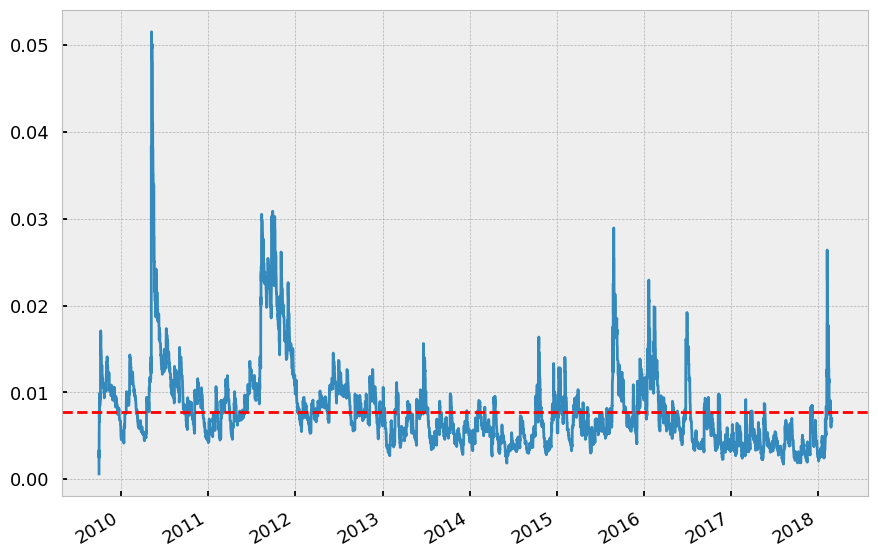

In [22]:
f,ax=plt.subplots()
dailyVol.plot(ax=ax)
ax.axhline(dailyVol.mean(),ls='--',color='r')


In [23]:
tEvents = getTEvents(close,h=dailyVol.mean())
tEvents

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30858/30858 [00:00<00:00, 49264.31it/s]


DatetimeIndex(['2009-09-29 09:33:01', '2009-09-30 09:45:21',
               '2009-09-30 13:31:12', '2009-10-01 09:43:58',
               '2009-10-01 11:12:07', '2009-10-02 09:44:14',
               '2009-10-02 10:35:05', '2009-10-05 09:51:42',
               '2009-10-05 14:55:48', '2009-10-06 09:29:52',
               ...
               '2018-02-16 14:23:51', '2018-02-20 09:30:00',
               '2018-02-20 15:21:07', '2018-02-21 14:04:12',
               '2018-02-21 15:12:30', '2018-02-22 12:18:21',
               '2018-02-22 14:56:14', '2018-02-23 11:37:32',
               '2018-02-23 15:58:39', '2018-02-26 13:06:34'],
              dtype='datetime64[ns]', length=2278, freq=None)

### (b) Add vertical barrier

In [24]:
t1 = addVerticalBarrier(tEvents, close, numDays=1)
t1

2009-09-29 09:33:01   2009-09-30 09:45:21
2009-09-30 09:45:21   2009-10-01 10:00:48
2009-09-30 13:31:12   2009-10-01 13:33:25
2009-10-01 09:43:58   2009-10-02 09:44:14
2009-10-01 11:12:07   2009-10-02 11:50:21
                              ...        
2018-02-21 15:12:30   2018-02-22 15:16:50
2018-02-22 12:18:21   2018-02-23 12:30:16
2018-02-22 14:56:14   2018-02-23 15:02:21
2018-02-23 11:37:32   2018-02-26 09:30:00
2018-02-23 15:58:39   2018-02-26 09:30:00
Length: 2277, dtype: datetime64[ms]

### (c) Apply triple-barrier method where ptSl = [1,1] and t1 is the series created in 1.b

In [35]:
# create target series
ptsl = [1,1]
target=dailyVol
# select minRet
minRet = 0.01

# Run in single-threaded mode on Windows
import platform
if platform.system() == "Windows":
    cpus = 1
else:
    cpus = cpu_count() - 1
print(f'cpus = {cpus}')
    
events = getEvents(close,tEvents,ptsl,target,minRet,cpus,t1=t1)
print(events)


cpus = 11


KeyError: "[Timestamp('2009-09-29 09:33:01')] not in index"

### (d) Apply getBins to generate labels

In [ ]:
labels = getBins(events, close)
cprint(labels)
print(labels.bin.value_counts())

### [3.2] Use snippet 3.8 to drop under-populated labels

In [ ]:
clean_labels = dropLabels(labels)
cprint(clean_labels)

In [ ]:
clean_labels.bin.value_counts()

### [3.3] Adjust the getBins function to return a 0 whenever the vertical barrier is the one touched first.

In [ ]:
def getBinsNew(events, close, t1=None):
    '''
    Compute event's outcome (including side information, if provided).
    events is a DataFrame where:
    -events.index is event's starttime
    -events['t1'] is event's endtime
    -events['trgt'] is event's target
    -events['side'] (optional) implies the algo's position side
    -t1 is original vertical barrier series
    Case 1: ('side' not in events): bin in (-1,1) <-label by price action
    Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    '''
    #1) prices aligned with events
    events_=events.dropna(subset=['t1'])
    px=events_.index.union(events_['t1'].values).drop_duplicates()
    px=close.reindex(px,method='bfill')
    #2) create out object
    out=pd.DataFrame(index=events_.index)
    out['ret']=px.loc[events_['t1'].values].values/px.loc[events_.index]-1
    if 'side' in events_:out['ret']*=events_['side'] # meta-labeling
    out['bin']=np.sign(out['ret'])
    
    if 'side' not in events_:
        # only applies when not meta-labeling
        # to update bin to 0 when vertical barrier is touched, we need the original
        # vertical barrier series since the events['t1'] is the time of first 
        # touch of any barrier and not the vertical barrier specifically. 
        # The index of the intersection of the vertical barrier values and the 
        # events['t1'] values indicate which bin labels needs to be turned to 0
        vtouch_first_idx = events[events['t1'].isin(t1.values)].index
        out.loc[vtouch_first_idx, 'bin'] = 0.
    
    if 'side' in events_:out.loc[out['ret']<=0,'bin']=0 # meta-labeling
    return out


### [3.4] Develop moving average crossover strategy. For each obs. the model suggests a side but not size of the bet

In [ ]:
fast_window = 3
slow_window = 7

close_df = (pd.DataFrame()
            .assign(price=close)
            .assign(fast=close.ewm(fast_window).mean())
            .assign(slow=close.ewm(slow_window).mean()))
cprint(close_df)

In [ ]:
def get_up_cross(df):
    crit1 = df.fast.shift(1) < df.slow.shift(1)
    crit2 = df.fast > df.slow
    return df.fast[(crit1) & (crit2)]

def get_down_cross(df):
    crit1 = df.fast.shift(1) > df.slow.shift(1)
    crit2 = df.fast < df.slow
    return df.fast[(crit1) & (crit2)]

up = get_up_cross(close_df)
down = get_down_cross(close_df)

f, ax = plt.subplots(figsize=(11,8))

close_df.loc['2014':].plot(ax=ax, alpha=.5)
up.loc['2014':].plot(ax=ax,ls='',marker='^', markersize=7,
                     alpha=0.75, label='upcross', color='g')
down.loc['2014':].plot(ax=ax,ls='',marker='v', markersize=7, 
                       alpha=0.75, label='downcross', color='r')

ax.legend()

### (a) Derive meta-labels for ptSl = [1,2] and t1 where numdays=1. Use as trgt dailyVol computed by snippet 3.1 (get events with sides)

In [ ]:
side_up = pd.Series(1, index=up.index)
side_down = pd.Series(-1, index=down.index)
side = pd.concat([side_up,side_down]).sort_index()
cprint(side)


In [ ]:
minRet = .01 
ptsl=[1,2]

dailyVol = getDailyVol(close_df['price'])
tEvents = getTEvents(close_df['price'],h=dailyVol.mean())
t1 = addVerticalBarrier(tEvents, close_df['price'], numDays=1)

ma_events = getEvents(close_df['price'],tEvents,ptsl,target,minRet,cpus,
                      t1=t1,side=side)
cprint(ma_events)


In [ ]:
ma_events.side.value_counts()

In [ ]:
ma_side = ma_events.dropna().side

In [ ]:
ma_bins = getBinsNew(ma_events,close_df['price'], t1).dropna()
cprint(ma_bins)


In [ ]:
Xx = pd.merge_asof(ma_bins, side.to_frame().rename(columns={0:'side'}),
                   left_index=True, right_index=True, direction='forward')
cprint(Xx)


In [ ]:
### (b) Train Random Forest to decide whether to trade or not {0,1} since underlying model (crossing m.a.) has decided the side, {-1,1}

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report

In [ ]:
X = ma_side.values.reshape(-1,1)
#X = Xx.side.values.reshape(-1,1)
y = ma_bins.bin.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,
                                                    shuffle=False)

n_estimator = 10000
rf = RandomForestClassifier(max_depth=2, n_estimators=n_estimator,
                            criterion='entropy', random_state=RANDOM_STATE)
rf.fit(X_train, y_train)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
### [3.5] Develop mean-reverting Bollinger Band Strategy. For each obs. model suggests a side but not size of the bet.

In [ ]:
def bbands(price, window=None, width=None, numsd=None):
    """ returns average, upper band, and lower band"""
    ave = price.rolling(window).mean()
    sd = price.rolling(window).std(ddof=0)
    if width:
        upband = ave * (1+width)
        dnband = ave * (1-width)
        return price, np.round(ave,3), np.round(upband,3), np.round(dnband,3)        
    if numsd:
        upband = ave + (sd*numsd)
        dnband = ave - (sd*numsd)
        return price, np.round(ave,3), np.round(upband,3), np.round(dnband,3)

In [ ]:
window=50
bb_df = pd.DataFrame()
bb_df['price'],bb_df['ave'],bb_df['upper'],bb_df['lower']=bbands(close, window=window, numsd=1)
bb_df.dropna(inplace=True)
cprint(bb_df)

In [ ]:
f,ax=plt.subplots(figsize=(11,8))
bb_df.loc['2014'].plot(ax=ax)

In [ ]:
def get_up_cross(df, col):
    # col is price column
    crit1 = df[col].shift(1) < df.upper.shift(1)  
    crit2 = df[col] > df.upper
    return df[col][(crit1) & (crit2)]

def get_down_cross(df, col):
    # col is price column    
    crit1 = df[col].shift(1) > df.lower.shift(1) 
    crit2 = df[col] < df.lower
    return df[col][(crit1) & (crit2)]

bb_down = get_down_cross(bb_df, 'price')
bb_up = get_up_cross(bb_df, 'price') 

f, ax = plt.subplots(figsize=(11,8))

bb_df.loc['2014':].plot(ax=ax, alpha=.5)
bb_up.loc['2014':].plot(ax=ax, ls='', marker='^', markersize=7,
                        alpha=0.75, label='upcross', color='g')
bb_down.loc['2014':].plot(ax=ax, ls='', marker='v', markersize=7, 
                          alpha=0.75, label='downcross', color='r')
ax.legend()


### (a) Derive meta-labels for ptSl=[0,2] and t1 where numdays=1. Use as trgt dailyVol.

In [ ]:
bb_side_up = pd.Series(-1, index=bb_up.index) # sell on up cross for mean reversion
bb_side_down = pd.Series(1, index=bb_down.index) # buy on down cross for mean reversion
bb_side_raw = pd.concat([bb_side_up,bb_side_down]).sort_index()
cprint(bb_side_raw)

minRet = .01 
ptsl=[0,2]
bb_events = getEvents(close,tEvents,ptsl,target,minRet,cpus,t1=t1,side=bb_side_raw)
cprint(bb_events)

bb_side = bb_events.dropna().side
cprint(bb_side)

In [ ]:
bb_side.value_counts()

In [ ]:
bb_bins = getBins(bb_events,close).dropna()
cprint(bb_bins)
print(bb_bins.bin.value_counts())

### (b) train random forest to decide to trade or not. Use features: volatility, serial correlation, and the crossing moving averages from exercise 2.

In [ ]:
def returns(s):
    arr = np.diff(np.log(s))
    return (pd.Series(arr, index=s.index[1:]))

def df_rolling_autocorr(df, window, lag=1):
    """Compute rolling column-wise autocorrelation for a DataFrame."""

    return (df.rolling(window=window)
            .corr(df.shift(lag))) # could .dropna() here

#df_rolling_autocorr(d1, window=21).dropna().head()



In [ ]:
srl_corr = df_rolling_autocorr(returns(close), window=window).rename('srl_corr')
cprint(srl_corr)

In [ ]:
features = (pd.DataFrame()
            .assign(vol=bb_events.trgt)
            .assign(ma_side=ma_side)
            .assign(srl_corr=srl_corr)
            .drop_duplicates()
            .dropna())
cprint(features)


In [ ]:
Xy = (pd.merge_asof(features, bb_bins[['bin']], 
                    left_index=True, right_index=True, 
                    direction='forward').dropna())
cprint(Xy)

In [ ]:
Xy.bin.value_counts()

In [ ]:
X = Xy.drop('bin',axis=1).values
y = Xy['bin'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,
                                                    shuffle=False)

n_estimator = 10000
rf = RandomForestClassifier(max_depth=2, n_estimators=n_estimator,
                            criterion='entropy', random_state=RANDOM_STATE)
rf.fit(X_train, y_train)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred, target_names=['no_trade','trade']))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### (c) What is accuracy of predictions from primary model if the secondary model does not filter bets? What is classification report?

In [ ]:
minRet = .01 
ptsl=[0,2]
bb_events = getEvents(close,tEvents,ptsl,target,minRet,cpus,t1=t1)
cprint(bb_events)

bb_bins = getBins(bb_events,close).dropna()
cprint(bb_bins)

features = (pd.DataFrame()
            .assign(vol=bb_events.trgt)
            .assign(ma_side=ma_side)
            .assign(srl_corr=srl_corr)
            .drop_duplicates()
            .dropna())
cprint(features)

Xy = (pd.merge_asof(features, bb_bins[['bin']], 
                    left_index=True, right_index=True, 
                    direction='forward').dropna())
cprint(Xy)

### run model ###
X = Xy.drop('bin',axis=1).values
y = Xy['bin'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,
                                                    shuffle=False)

n_estimator = 10000
rf = RandomForestClassifier(max_depth=2, n_estimators=n_estimator,
                            criterion='entropy', random_state=RANDOM_STATE)
rf.fit(X_train, y_train)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred, 
                            target_names=['no_trade','trade']))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()